<a href="https://colab.research.google.com/github/Ainapalma/pytorch-image-classification/blob/main/imagewoof_classifier_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data loading and pre-processing

In [ ]:
import torch                                            
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as tt

from torchvision.datasets.utils import download_url
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torchsummary import summary

import matplotlib
import matplotlib.pyplot as plt
import multiprocessing
import os, tarfile, time

In [ ]:
# Download the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/imagewoof-160.tgz"
download_url(dataset_url, '.')

# Extract the archive
with tarfile.open('./imagewoof-160.tgz', 'r:gz') as tar: 
  tar.extractall(path = './data')

Using downloaded and verified file: ./imagewoof-160.tgz


In [ ]:
# Set the data directory paths
data_dir = './data/imagewoof-160'
print(os.listdir(data_dir))

['val', 'train']


In [ ]:
# Set the model save path
path = 'imagewoof.pth'

In [ ]:
# Number of workers
num_cpu = multiprocessing.cpu_count()
num_cpu

2

In [ ]:
# Set generator
random_seed = 42
torch.manual_seed(random_seed)

In [ ]:
# Check folders and length
print(os.listdir('./data/imagewoof-160/train'))
print(len(os.listdir('./data/imagewoof-160/train')))

['n02086240', 'n02111889', 'n02089973', 'n02093754', 'n02087394', 'n02105641', 'n02096294', 'n02099601', 'n02115641', 'n02088364']
10


In [ ]:
# Create class names
class_names = ['Australian terrier', 
           'Border terrier', 
           'Samoyed', 
           'Beagle', 
           'Shih-Tzu', 
           'English foxhound', 
           'Rhodesian ridgeback', 
           'Dingo', 
           'Golden retriever', 
           'Old English sheepdog']

len(class_names)

10

In [ ]:
# Count images in each class of train set
train_directory = './data/imagewoof-160/train'

for root, dirs, files in os.walk(train_directory):
  if files == []:
    continue
  else:
    print(len(files))

1300
1300
754
1300
1300
1300
1300
1300
1300
1300


In [ ]:
# Count images in each class of test set
test_directory = './data/imagewoof-160/val'

for root, dirs, files in os.walk(test_directory):
  if files == []:
    continue
  else:
    print(len(files))

50
50
50
50
50
50
50
50
50
50


In [ ]:
# Transform all the images into tensors
image_size_test = ImageFolder(train_directory, tt.ToTensor())

In [ ]:
# Calculate mean and stanard deviation for normalization
means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in image_size_test:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(image_size_test)
stds /= len(image_size_test)
    
print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.4876, 0.4571, 0.3953])
Calculated stds: tensor([0.2209, 0.2151, 0.2169])


In [ ]:
# Checking the size of the first 10 images
im_count = 0
for image,_ in image_size_test:
  im_count += 1
  print(image.shape)
  if im_count == 10:
    break    

torch.Size([3, 160, 213])
torch.Size([3, 160, 213])
torch.Size([3, 213, 160])
torch.Size([3, 160, 213])
torch.Size([3, 160, 192])
torch.Size([3, 160, 211])
torch.Size([3, 160, 219])
torch.Size([3, 213, 160])
torch.Size([3, 160, 213])
torch.Size([3, 160, 213])


In [ ]:
# Finding the maximum and minimum size of the images
height = []
width = []
for image,_ in image_size_test:
  height.append(image.shape[1])
  width.append(image.shape[2])
print("minimum height: {}, maximum height: {}, minimum width: {}, maximum width: {}".format(min(height), max(height), min(width), max(width)))

minimum height: 160, maximum height: 391, minimum width: 160, maximum width: 615


In [ ]:
# Applying transforms to the data including resizing to 160x160
means = [0.4876, 0.4571, 0.3953]
stds = [0.2209, 0.2151, 0.2169]

image_transforms = {
    'train': tt.Compose([tt.RandomCrop(160, padding=1, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(),
                         tt.RandomRotation(degrees=15),
                         tt.ToTensor(),
                         tt.Normalize(mean = means, std = stds)]),
    'test': tt.Compose([tt.RandomResizedCrop(160),
                        tt.ToTensor(), tt.Normalize(mean = means, std = stds)])
}

In [ ]:
# Load data from folders
dataset = {
    'train_full': ImageFolder(root=data_dir + '/train', transform=image_transforms['train']),
    'test': ImageFolder(root=data_dir + '/val', transform=image_transforms['test'])
}

In [ ]:
# Double checking after resizing

height = []
width = []
for image,_ in dataset['train_full']:
  height.append(image.shape[1])
  width.append(image.shape[2])
print("minimum height: {}, maximum height: {}, minimum width: {}, maximum width: {}".format(min(height), max(height), min(width), max(width)))

minimum height: 160, maximum height: 160, minimum width: 160, maximum width: 160


In [ ]:
# Function to display sample
def show_example(img,label):
  print('Label: ', class_names[label], '('+str(label)+')')
  plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  Australian terrier (0)


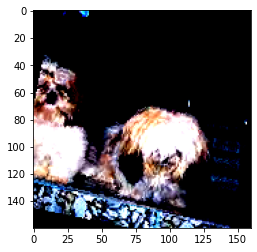

In [ ]:
# Sample 42
show_example(*dataset['train_full'][42])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  Australian terrier (0)


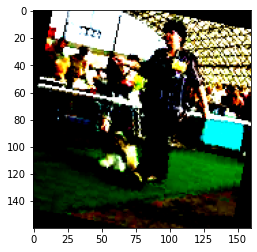

In [ ]:
# Sample 808
show_example(*dataset['train_full'][808])

In [ ]:
# Split the dataset to training and validation
val_size = 0.95

n_train_examples = int(len(dataset['train_full']) * val_size)
n_valid_examples = len(dataset['train_full']) - n_train_examples

train_set, val_set = random_split(dataset['train_full'], 
                                           [n_train_examples, n_valid_examples])

print(f"Number of training examples: {len(train_set)}")
print(f"Number of validation examples: {len(val_set)}")

Number of training examples: 11831
Number of validation examples: 623


In [ ]:
# Loading the data by batches
batch_size = 64

train_loaded = DataLoader(train_set, batch_size, 
                      shuffle = True, num_workers=num_cpu, pin_memory=True)
val_loaded = DataLoader(val_set, batch_size, 
                    num_workers=num_cpu, pin_memory=True)

In [ ]:
# Functions for plotting batch
def denormalize(images, means, stds):
  means = torch.tensor(means).reshape(1,3,1,1)
  stds = torch.tensor(stds).reshape(1,3,1,1,)
  return images * stds + means

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize = (12,12))
    ax.set_xticks([]), ax.set_yticks([])
    denorm_images = denormalize(images, means, stds)
    ax.imshow(make_grid(denorm_images[:64],nrow = 8).permute(1,2,0).clamp(0,1))
    break

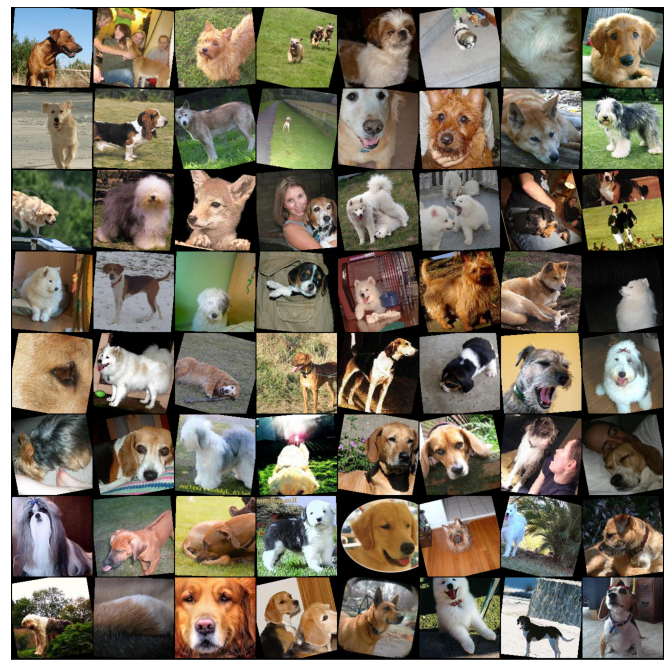

In [ ]:
show_batch(train_loaded)

## Building and training a model

In [ ]:
# Accuracy function
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
# Base class
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
# Defining a model
class Imagewoof(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(4, 4),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(4, 4),

            nn.Flatten(), 
            nn.Linear(1024 * 5 * 5, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = Imagewoof()

In [ ]:
# Move tensor to chosen device  
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# Move data to a device
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
# Picking GPU if available, else CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
# Transferring batches of data and moving model to the GPU if available
train_dl = DeviceDataLoader(train_loaded, device)
val_dl = DeviceDataLoader(val_loaded, device)
to_device(model, device)

Imagewoof(
  (network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=25600, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_featur

In [ ]:
# Checking summary
summary(model, (3, 160, 160), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 64, 160, 160]           1,792
              ReLU-2         [64, 64, 160, 160]               0
            Conv2d-3        [64, 128, 160, 160]          73,856
              ReLU-4        [64, 128, 160, 160]               0
         MaxPool2d-5          [64, 128, 40, 40]               0
            Conv2d-6          [64, 256, 40, 40]         295,168
              ReLU-7          [64, 256, 40, 40]               0
            Conv2d-8          [64, 512, 40, 40]       1,180,160
              ReLU-9          [64, 512, 40, 40]               0
        MaxPool2d-10          [64, 512, 20, 20]               0
           Conv2d-11          [64, 512, 20, 20]       2,359,808
             ReLU-12          [64, 512, 20, 20]               0
           Conv2d-13         [64, 1024, 20, 20]       4,719,616
             ReLU-14         [64, 1024,

In [ ]:
@torch.no_grad()
# Evaluate performance on the validation set
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# Fit and evaluate to train the model using gradient descent
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
# Evaluating the model the initial set of parameters
model = to_device(Imagewoof(), device)
evaluate(model, val_dl)

{'val_acc': 0.10495345294475555, 'val_loss': 2.3012497425079346}

In [ ]:
%%time
# Fitting model
num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.0001

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [1], train_loss: 2.1177, val_loss: 2.0212, val_acc: 0.2473
Epoch [2], train_loss: 1.9656, val_loss: 1.9207, val_acc: 0.3032
Epoch [3], train_loss: 1.8477, val_loss: 1.7922, val_acc: 0.3714
Epoch [4], train_loss: 1.7488, val_loss: 1.7252, val_acc: 0.3882
Epoch [5], train_loss: 1.6478, val_loss: 1.6984, val_acc: 0.4018
Epoch [6], train_loss: 1.5532, val_loss: 1.5591, val_acc: 0.4729
Epoch [7], train_loss: 1.4538, val_loss: 1.5053, val_acc: 0.4894
Epoch [8], train_loss: 1.3706, val_loss: 1.4298, val_acc: 0.5141
Epoch [9], train_loss: 1.3059, val_loss: 1.3452, val_acc: 0.5141
Epoch [10], train_loss: 1.2177, val_loss: 1.3006, val_acc: 0.5423
Epoch [11], train_loss: 1.1689, val_loss: 1.2086, val_acc: 0.5718
Epoch [12], train_loss: 1.0866, val_loss: 1.2464, val_acc: 0.5791
Epoch [13], train_loss: 1.0382, val_loss: 1.2523, val_acc: 0.5567
Epoch [14], train_loss: 0.9927, val_loss: 1.2127, val_acc: 0.5887
Epoch [15], train_loss: 0.9224, val_loss: 1.1922, val_acc: 0.5999
CPU times: user 5mi

In [ ]:
'''%%time
history += fit(3, 0.005, model, train_dl, val_dl, opt_func)'''

Epoch [1], train_loss: 2.3605, val_loss: 2.2916, val_acc: 0.1013
Epoch [2], train_loss: 2.2941, val_loss: 2.2868, val_acc: 0.1168
Epoch [3], train_loss: 2.2937, val_loss: 2.2866, val_acc: 0.0767
CPU times: user 1min 4s, sys: 1min 3s, total: 2min 7s
Wall time: 2min 14s


In [ ]:
'''%%time
history += fit(3, 0.01, model, train_dl, val_dl, opt_func)'''

Epoch [1], train_loss: 2.2940, val_loss: 2.2891, val_acc: 0.0767
Epoch [2], train_loss: 2.2942, val_loss: 2.2885, val_acc: 0.1013
Epoch [3], train_loss: 2.2944, val_loss: 2.2892, val_acc: 0.1024
CPU times: user 1min 4s, sys: 1min 3s, total: 2min 7s
Wall time: 2min 14s


In [ ]:
'''%%time
history += fit(3, 0.000001, model, train_dl, val_dl, opt_func)'''

Epoch [1], train_loss: 2.2934, val_loss: 2.2887, val_acc: 0.1024
Epoch [2], train_loss: 2.2934, val_loss: 2.2887, val_acc: 0.1024
Epoch [3], train_loss: 2.2934, val_loss: 2.2887, val_acc: 0.1024
CPU times: user 1min 3s, sys: 1min 4s, total: 2min 7s
Wall time: 2min 14s


## Performance analysis and testing

In [ ]:
# Functions to plot accuracy and loss
def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel(['accuracy'])
  plt.title('Accuracy vs No. of epoch')

def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['val_loss'] for x in history]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training','Validation'])
  plt.title('Loss vs No. of epoch')

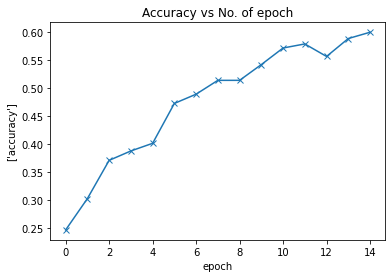

In [ ]:
plot_accuracies(history)

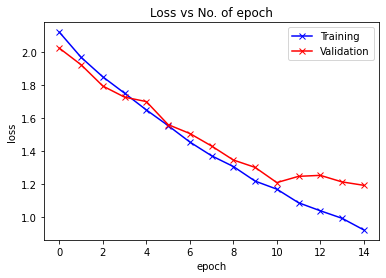

In [ ]:
plot_losses(history)

In [ ]:
# Checking one sample prediction
def predict_image(img, model):
  xb = to_device(img.unsqueeze(0),device)
  yb = model(xb)
  _, preds = torch.max(yb, dim = 1)
  return class_names[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: Australian terrier , Predicted: Australian terrier


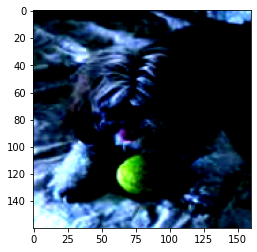

In [ ]:
img, label = dataset['test'][0]
plt.imshow(img.permute(1,2,0))
print("Label:", class_names[label], ', Predicted:', predict_image(img,model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: Rhodesian ridgeback , Predicted: Golden retriever


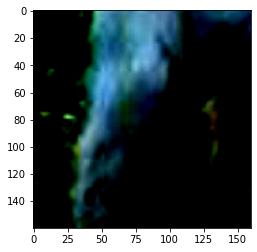

In [ ]:
img, label = dataset['test'][333]
plt.imshow(img.permute(1,2,0))
print("Label:", class_names[label], ', Predicted:', predict_image(img,model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: Old English sheepdog , Predicted: Old English sheepdog


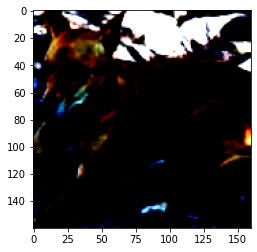

In [ ]:
img, label = dataset['test'][455]
plt.imshow(img.permute(1,2,0))
print("Label:", class_names[label], ', Predicted:', predict_image(img,model))

In [ ]:
# Testing model on hidden set
test_loader = DeviceDataLoader(DataLoader(dataset['test'], batch_size), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.4140625, 'val_loss': 1.8356329202651978}

In [ ]:
# Save the entire model
print("\nSaving the model...")
torch.save(model, path)